In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style='darkgrid')

# Utilities: Internal supporting functions

## ```remove_outliers_modz```
Source: https://medium.com/towards-data-science/3-simple-statistical-methods-for-outlier-detection-db762e86cd9d

In [4]:
# Calculate Mod-Z score
# Converted to a funciton so I can call it from get_cleansed_data() to refresh the data repeatedly

import time

def remove_outliers_modz(df_with_outliers, indent_output=False):
    """
    Removes outliers based on the Modified Z-score covered in the article

    :param df_with_outliers: Raw data to be cleaned
    :param indent_output: Set to true if you're embedding this inisde your print statements
    :return: Returns DF with outliers removed
    """
        
    # Apply the above function to the entire column to get a modified
    # z score for every data point.
    # temp = vehicles_raw#[0:100000]
    temp = df_with_outliers
    modz = (np.abs(temp['price'] - temp['price'].median())).median()
    med = temp['price'].median()
    const = 0.6745
    print('... ', end='') if indent_output else None
    print('ModZ: {}, med: {}, const: {}'.format(modz, med, const))
    
    start_time = time.time()
    temp['mod_zscore'] = temp['price'].transform(lambda x: (const * (x - med) / modz))
    end_time = time.time()
    print('... ', end='') if indent_output else None
    print('Time: {}'.format(end_time - start_time))
    
    return temp[(temp['mod_zscore'] >= -3.5) & (temp['mod_zscore'] <= 3.5)]

## ```value_counts_2df```

In [6]:
def value_counts_2df(df1, df2, df1_label, df2_label, column, dropna=True):
    """
    Returns the value_counts of two DataFrames that have a common column

    :param df1: First DF
    :param df2: Second DF
    :param df1_label: Label for the counts of DF1
    :param df2_label: Label for the counts of DF2
    :param column: Column to count the values
    :param dropna: Default is true, over-ride to get NaN counts also
    """
        
    # Count the occurrences of each key in both DataFrames separately
    count_df1 = df1[column].value_counts(dropna=dropna).reset_index()
    count_df1.columns = [column, df1_label]
    
    count_df2 = df2[column].value_counts(dropna=dropna).reset_index()
    count_df2.columns = [column, df2_label]
    
    # Merge the counts into a single DataFrame
    result = pd.merge(count_df1, count_df2, on=column, how='outer').fillna(0)
    
    # Convert counts to integers
    result[df1_label] = result[df1_label].astype(int)
    result[df2_label] = result[df2_label].astype(int)

    return result

## ```get_cleansed_data```

In [8]:
def get_cleansed_data():

    raw = pd.DataFrame()

    # Read input file
    file = 'data/vehicles.csv'
    print('Reading {} ... '.format(file), end='')
    raw = pd.read_csv(file)
    print('Done: {}'.format(raw.shape))

    # make a copy of raw data and start to cleanse it
    cleansed = raw.copy()

    # Handle price: remove outliers, mod-zscore column will be dropped later
    print('\nCleansing price column ... ')
    before = cleansed.shape
    print('... Removing price outliers using ModZ method ... ')
    cleansed = remove_outliers_modz(raw, indent_output=True)
    print('... Removed {:,d} rows'.format(before[0] - cleansed.shape[0]))
    before = cleansed.shape
    print('... Removing rows with price = 0 ... ', end='')
    cleansed = cleansed.query('price > 0')
    print(' Removed {:,d} rows'.format(before[0] - cleansed.shape[0]))
    after = cleansed.shape
    print('Done: {} -> {}'.format(before, after))

    # Handle dropna() columns
    dropna_cols = ['year', 'manufacturer', 'fuel', 'title_status', 'odometer', 'transmission']

    before_t = cleansed.shape
    print('\nDropNA from columns: ')
    null_cnt = 0
    for col in dropna_cols:
        before = cleansed.shape[0]
        null_cnt += cleansed[col].isnull().sum()
        print('... {}: {:,d} rows ({:,.2f}% of total): {:,d} -> {:,d}'
              .format(col, null_cnt, (1 - (before - null_cnt) / before) * 100, before, before - null_cnt))

    cleansed = cleansed.dropna(subset=dropna_cols)
    print('Done: {} -> {}'.format(before_t, cleansed.shape))

    # handle columns to be dropped
    drop_cols = ['mod_zscore', 'id', 'model']
    before = cleansed.shape
    print('\nDropping columns: ' + str(drop_cols))
    for col in drop_cols:
        print('... {}'.format(col))
    cleansed = cleansed.drop(columns=drop_cols)
    after = cleansed.shape
    print('Done: {} -> {}'.format(before, after))
    
    print('\nReturned Raw({:,d}x{}) and Cleansed({:,d}x{}) data'.format(raw.shape[0], raw.shape[1], 
                                                                        cleansed.shape[0], cleansed.shape[1]))
    print('Dataset reduced by {:,d} rows (preserved {:,.2f} of total)'.format(raw.shape[0] - cleansed.shape[0],
                                                                              (cleansed.shape[0] / raw.shape[0]) * 100))
    
    return raw, cleansed

In [9]:
# r, c = get_cleansed_data()

# Data Inspection

In [11]:
# Read the data - we use the get_cleansed_data() function, which returns the finalized data,
# but will continue to use the vehicles_raw during the data investigation - this way, we do the
# reading and cleansing of the data in the same place

vehicles_raw, vehicles_cleansed = get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.1627509593963623
... Removed 5,790 rows
... Removing rows with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model']
... mod_zscore
... id
... model
Done: (360700, 19) -> (360700, 16)

Returned Raw(426,880x19) and Cleansed(360,700x16) data
Dataset reduced by 66,180 rows (preserved 84.50 of total)


In [12]:
vehicles_raw.head(2)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,mod_zscore
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,-0.567437
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,-0.146320


In [13]:
vehicles_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
 18  mod_

## Inspect: Nulls

In [15]:
print('Percent non-null values in each column')
vehicles_raw.isnull().sum().transform(lambda x: (1 - (x / vehicles_raw.shape[0])) * 100).round(2)

Percent non-null values in each column


id              100.00
region          100.00
price           100.00
year             99.72
manufacturer     95.87
model            98.76
condition        59.21
cylinders        58.38
fuel             99.29
odometer         98.97
title_status     98.07
transmission     99.40
VIN              62.27
drive            69.41
size             28.23
type             78.25
paint_color      69.50
state           100.00
mod_zscore      100.00
dtype: float64

In [16]:
vehicles_raw.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,426880.0,NaN,NaN,NaN,7311486634.224333,4473170.412559,7207408119.0,7308143339.25,7312620821.0,7315253543.5,7317101084.0
region,426880,404,columbus,3608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,426880.0,NaN,NaN,NaN,75199.033187,12182282.173604,0.0,5900.0,13950.0,26485.75,3736928711.0
year,425675.0,NaN,NaN,NaN,2011.235191,9.45212,1900.0,2008.0,2013.0,2017.0,2022.0
manufacturer,409234,42,ford,70985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,421603,29649,f-150,8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,252776,6,good,121456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,249202,8,6 cylinders,94169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,423867,5,gas,356209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,422480.0,NaN,NaN,NaN,98043.331443,213881.500798,0.0,37704.0,85548.0,133542.5,10000000.0


In [17]:
vehicles_raw.describe().style.format('{:,.2f}')

,id,price,year,odometer,mod_zscore
count,"426,880.00","426,880.00","425,675.00","422,480.00","426,880.00"
mean,"7,311,486,634.22","75,199.03","2,011.24","98,043.33",4.37
std,"4,473,170.41","12,182,282.17",9.45,"213,881.50",869.52
min,"7,207,408,119.00",0.00,"1,900.00",0.00,-1.00
25%,"7,308,143,339.25","5,900.00","2,008.00","37,704.00",-0.57
50%,"7,312,620,821.00","13,950.00","2,013.00","85,548.00",0.00
75%,"7,315,253,543.50","26,485.75","2,017.00","133,542.50",0.89
max,"7,317,101,084.00","3,736,928,711.00","2,022.00","10,000,000.00","266,724.76"


## Inspect: price

Since price will be our target parameter for models, let's check it first

### Price = 0 case

In [20]:
veh_zero_price = vehicles_raw.query('price == 0')
veh_zero_price.price.value_counts()

price
0    32895
Name: count, dtype: int64

In [21]:
veh_zero_price.describe().style.format('{:,.2f}')

,id,price,year,odometer,mod_zscore
count,"32,895.00","32,895.00","32,863.00","30,785.00","32,895.00"
mean,"7,311,551,883.13",0.00,"2,013.97","89,312.68",-1.00
std,"4,484,307.42",0.00,6.36,"297,007.17",0.00
min,"7,209,027,818.00",0.00,"1,903.00",0.00,-1.00
25%,"7,308,226,344.00",0.00,"2,012.00","34,908.00",-1.00
50%,"7,312,520,029.00",0.00,"2,015.00","72,000.00",-1.00
75%,"7,315,315,941.00",0.00,"2,017.00","110,000.00",-1.00
max,"7,317,080,869.00",0.00,"2,022.00","10,000,000.00",-1.00


In [22]:
veh_zero_price_pct = (veh_zero_price.shape[0] / vehicles_raw.shape[0]) * 100
veh_zero_price_pct

7.7059126686656665

There are 32,895 cars with a zero price, 7.71% of the total - reasonable candidates for exclusion!

### Price Distribution

Let's look at the price distribution of cars with non-zero prices

In [26]:
veh_priced = vehicles_raw.query('price > 0')

<Axes: >

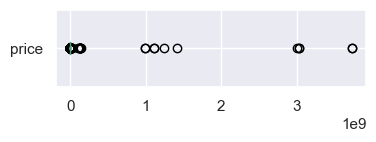

In [27]:
veh_priced.price.plot.box(vert=False, figsize=(4,1))

In [28]:
veh_priced.describe().T.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
id,"393,985.00","7,311,481,186.40","4,472,201.94","7,207,408,119.00","7,308,131,294.00","7,312,625,769.00","7,315,249,600.00","7,317,101,084.00"
price,"393,985.00","81,477.63","12,680,636.89",1.00,"7,000.00","15,000.00","27,590.00","3,736,928,711.00"
year,"392,812.00","2,011.01",9.63,"1,900.00","2,008.00","2,013.00","2,017.00","2,022.00"
odometer,"391,695.00","98,729.51","205,915.79",0.00,"38,000.00","87,000.00","135,334.00","10,000,000.00"
mod_zscore,"393,985.00",4.82,905.09,-1.00,-0.50,0.07,0.97,"266,724.76"


The price min/max is all over the place and the quartile distribution is strange - let's dig deeper into this when we look at outliers later

Let's look at cars under 100K

<Axes: ylabel='Count'>

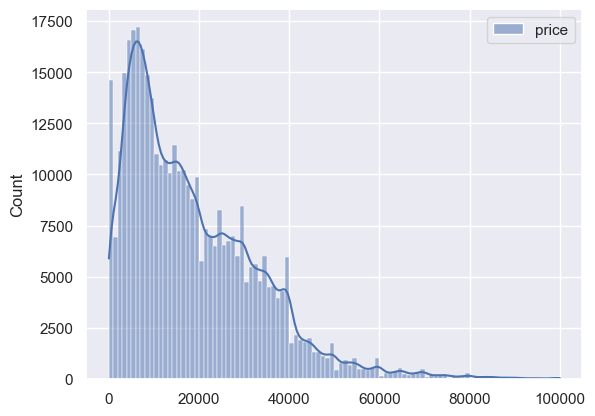

In [30]:
price_cap = 100000
sns.histplot(vehicles_raw.query('price > 0 and price <= @price_cap')[['price']], bins=100, kde=True)

Massive skew - let's play with outliers now

### Price Outliers

#### Outliers Method 1: Simple quartile analysis

In [34]:
# Calculate IQR
Q1 = vehicles_raw['price'].quantile(0.25)
Q3 = vehicles_raw['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
vehicles_iqr = vehicles_raw[(vehicles_raw['price'] >= lower_bound) & (vehicles_raw['price'] <= upper_bound)]

# Plot the distribution again
# plt.figure(figsize=(10, 6))
# sns.histplot(vehicles_iqr['price'], bins=30, kde=True)
# plt.title('Price Distribution After IQR [#Orig: {:,}; Removed: {:,}]'.
#           format(vehicles_raw.shape[0], vehicles_raw.shape[0] - vehicles_iqr.shape[0]))
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.show()

#### Outliers Method 2: Modified z-score

Refer to the Utilities section for the remove_outliers_modz() function

In [36]:
vehicles_modZ = remove_outliers_modz(vehicles_raw)
# vehicles_modZ

ModZ: 9450.0, med: 13950.0, const: 0.6745
Time: 0.1780080795288086


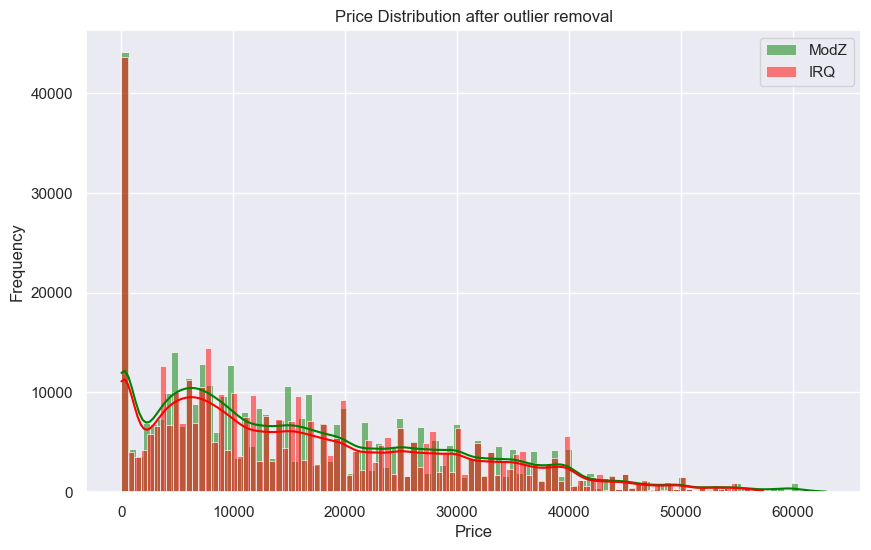

In [37]:
# Plot the distribution again
plt.figure(figsize=(10, 6))
sns.histplot(vehicles_modZ['price'], bins=100, kde=True, color='green', alpha=0.5, label='ModZ')
sns.histplot(vehicles_iqr['price'], bins=100, kde=True, color='red', alpha=0.5, label='IRQ')

plt.title('Price Distribution after outlier removal')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [38]:
print('vehicles_raw: shape: {}, min: {:,.2f}, max: {:,.2f}'.
      format(vehicles_raw.shape, vehicles_raw.price.min(), vehicles_raw.price.max()))
print('vehicles_iqr: shape: {}, min: {:,.2f}, max: {:,.2f}, Removed: {:,d}'.
      format(vehicles_iqr.shape, vehicles_iqr.price.min(), vehicles_iqr.price.max(), vehicles_raw.shape[0] - vehicles_iqr.shape[0]))
print('vehicles_modZ: shape: {}, min: {:,.2f}, max: {:,.2f}, Removed: {:,d}'.
      format(vehicles_modZ.shape, vehicles_modZ.price.min(), vehicles_modZ.price.max(), vehicles_raw.shape[0] - vehicles_modZ.shape[0]))

vehicles_raw: shape: (426880, 19), min: 0.00, max: 3,736,928,711.00
vehicles_iqr: shape: (418703, 19), min: 0.00, max: 57,341.00, Removed: 8,177
vehicles_modZ: shape: (421090, 19), min: 0.00, max: 62,981.00, Removed: 5,790


Based on the above distribution ModZ did preserved more data samples, i.e. removed only 5,790 instead of 8,177 priced vehicles, so let's analyze this further.

In [40]:
# Which set of vehicles are we looking at ...
# vehicles_sel = vehicles_raw
vehicles_sel = vehicles_modZ

In [41]:
vehicles_sel.describe().T.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
id,"421,090.00","7,311,485,749.33","4,473,251.79","7,207,408,119.00","7,308,145,995.25","7,312,617,063.00","7,315,252,755.50","7,317,101,084.00"
price,"421,090.00","16,588.75","13,510.01",0.00,"5,800.00","13,500.00","25,988.00","62,981.00"
year,"420,029.00","2,011.19",9.38,"1,900.00","2,008.00","2,013.00","2,017.00","2,022.00"
odometer,"416,750.00","98,859.49","214,470.24",0.00,"38,922.00","86,830.00","134,231.00","10,000,000.00"
mod_zscore,"421,090.00",0.19,0.96,-1.00,-0.58,-0.03,0.86,3.50


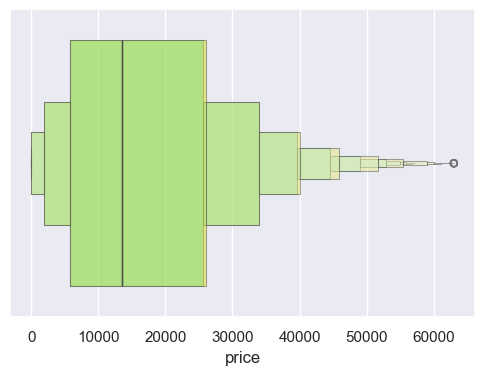

In [42]:
plt.figure(figsize=(6,4))
sns.boxenplot(data=vehicles_iqr, x='price', alpha=0.5, color='cyan')
sns.boxenplot(data=vehicles_modZ, x='price', alpha=0.5, color='yellow')
plt.show()

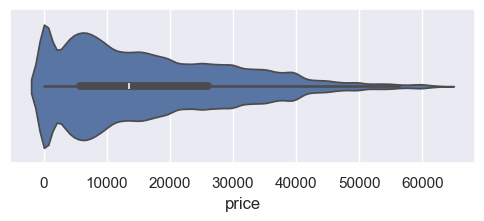

In [43]:
plt.figure(figsize=(6,2))
sns.violinplot(data=vehicles_sel, x='price')
plt.show()

### Price segmentation analysis

Looking at the above violin plot, let's look at price-based segments, **there seems to be at least a low- and mid-price band with a long tail that can be high-priced autos**

#### Market Research Resources 

1. [Auto Remarketing, July 2023: Mid-Year Market Report: Dissecting used-car pricing, segment trends, CPO sales & more](http://digital.autoremarketing.com/publication/frame.php?i=794065&p=&pn=&ver=html5&view=articleBrowser&article_id=4594802)

    * "Avearge used vehicle transaction price in the first quaretr actually dipped by 6.4% year-over-year to \\$28,381, compared to \\$30,329 in Q1 2022"

<Axes: xlabel='price', ylabel='Count'>

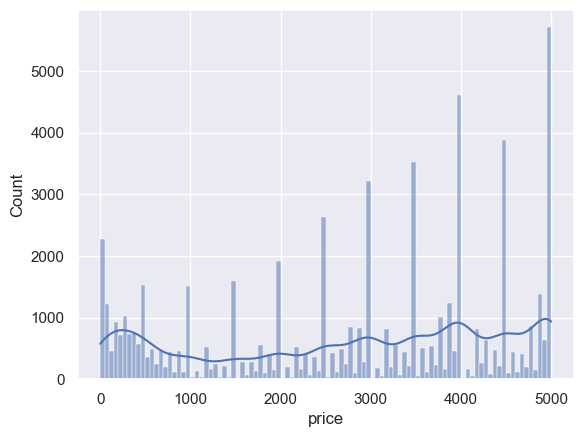

In [45]:
low_price_max = 5000
veh_low_priced = vehicles_sel.query('price > 0 and price <= @low_price_max')
sns.histplot(veh_low_priced.price, bins=100, kde=True)

In [46]:
veh_low_price_upto_1000 = vehicles_sel.query('price > 0 and price <= 1000')
veh_low_price_upto_2000 = vehicles_sel.query('price > 1000 and price <= 2000')
veh_low_price_upto_3000 = vehicles_sel.query('price > 2000 and price <= 3000')
veh_low_price_upto_4000 = vehicles_sel.query('price > 3000 and price <= 4000')
veh_low_price_upto_5000 = vehicles_sel.query('price > 4000 and price <= 5000')

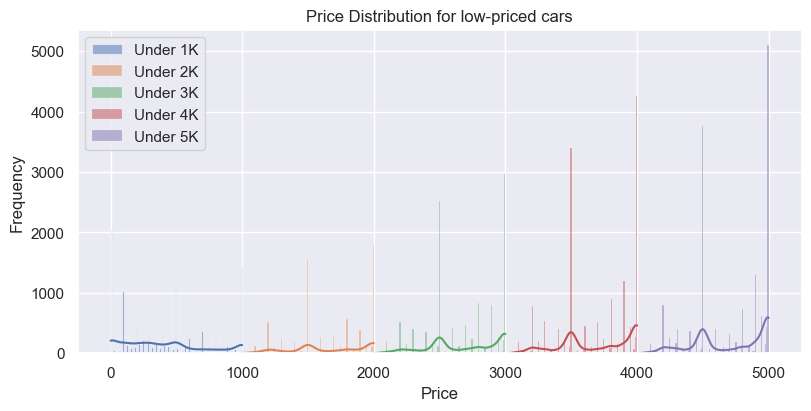

In [47]:
# Plot the distribution again
plt.figure(figsize=(8, 4), layout='constrained')
sns.histplot(veh_low_price_upto_1000.price, bins=100, kde=True, label='Under 1K', multiple='dodge')
sns.histplot(veh_low_price_upto_2000.price, bins=100, kde=True, label='Under 2K', multiple='dodge')
sns.histplot(veh_low_price_upto_3000.price, bins=100, kde=True, label='Under 3K', multiple='dodge')
sns.histplot(veh_low_price_upto_4000.price, bins=100, kde=True, label='Under 4K', multiple='dodge')
sns.histplot(veh_low_price_upto_5000.price, bins=100, kde=True, label='Under 5K', multiple='dodge')

plt.title('Price Distribution for low-priced cars')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Pricing Findings

* There are 32,895 cars with a zero price, 7.71% of the total (426,880) - these are candidates for exclusion pending further analysis
* The price distribution shows an extreme right-skew with a long-tail with a few outliers beyond \\$100K price point
* Analyzed outliers using two separate methods (quantile analysis and Modified z-score)
    * ModZ performed better, i.e. preserved more data samples - removing only 5,790 instead of 8,177 priced vehicles
* Looking at the distribution of priced cars:
    * There seems to be at least a low- and mid-price band with a long tail that can be high-priced autos**
    * Market research on used-car prices showed an average Q12023 price of \\$28,381

**Candidate Dataset**: Based on the above findings, these are three potential price-based segments of cars with prices:

* Low-priced cars: Under \\$5K
* Mid-priced cars: \\$5K - \\$50K
* High-priced cars: ABove \\$50K

![](images/candidate-price-segments.png)


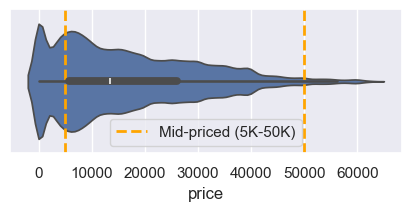

In [49]:
plt.figure(figsize=(4,2), layout='constrained')
plt.axvline(x=5000, color='orange', linestyle='--', linewidth=2, label='Mid-priced (5K-50K)')
plt.axvline(x=50000, color='orange', linestyle='--', linewidth=2)
sns.violinplot(data=vehicles_sel, x='price')
plt.show()

In [50]:
# Final candidate: Priced cars (price > 0) with outliers removed
veh_priced_no_outliers = vehicles_sel.query('price > 0')
vehicles_sel = veh_priced_no_outliers

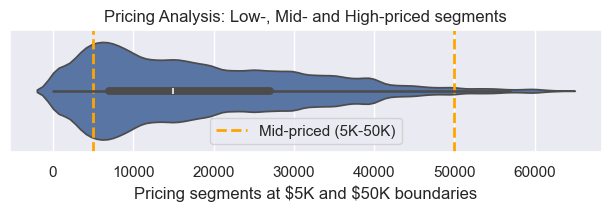

In [51]:
plt.figure(figsize=(6,2), layout='constrained')
plt.axvline(x=5000, color='orange', linestyle='--', linewidth=2, label='Mid-priced (5K-50K)')
plt.axvline(x=50000, color='orange', linestyle='--', linewidth=2)
sns.violinplot(data=veh_priced_no_outliers, x='price')

plt.title('Pricing Analysis: Low-, Mid- and High-priced segments')
plt.xlabel('Pricing segments at \\$5K and \\$50K boundaries')
plt.savefig('images/candidate-price-segments.png')
plt.show()

In [52]:
# Drop mod z-score column - we're done with outliers
vehicles_sel = vehicles_sel.drop('mod_zscore', axis=1)
vehicles_sel.shape

(388195, 18)

## Inspect: id

Analyzing the candidate dataset up to this point, showed NO null or duplicated data as it is a **unique ID** column

**We will _remove this column_ as it would affect the data modeling. We may come back to this after initial modeling**

In [54]:
col='id'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - id: raw: 0 sel: 0 => pct: 0.00%


In [55]:
col='id'
raw_null_c = vehicles_raw[col].duplicated().sum()
sel_null_c = vehicles_sel[col].duplicated().sum()
print('DUPES - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

DUPES - id: raw: 0 sel: 0 => pct: 0.00%


In [56]:
vehicles_sel = vehicles_sel.drop('id', axis=1)
vehicles_sel.shape

(388195, 17)

## Inspect: condition

1. There are 163,851 null values (40.55% of total)
2. This is a very high percentage, so we cannot simply remove these rows

**Intuitively, condition is likely a large determinant of final price, so we will leave all these values and take this into consideration during modeling**

In [58]:
print('condition.isnull(): raw: {:,d} sel: {:,d}'.format(vehicles_raw.condition.isnull().sum(), vehicles_sel.condition.isnull().sum()))

condition.isnull(): raw: 174,104 sel: 147,637


In [59]:
col='condition'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - condition: raw: 174,104 sel: 147,637 => pct: 38.03%


In [60]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', 'condition', dropna=False)

,condition,Raw#,Sel#
0,excellent,101467,93897
1,fair,6769,6715
2,good,121456,118761
3,like new,21178,19576
4,new,1305,1014
5,salvage,601,595
6,0,174104,147637


## Inspect: VIN

Analyzing the candidate dataset up to this point, showed a large number of null and duplicated data:

* Nulls: 159,512 representing 37.88% of samples
* Duplicates: 304,422 representing 72.29% of samples

**Given this, we will _not remove nulls or duplicates at this time_ as it would remove a large percentage of training data. We may come back to this after initial modeling**

In [62]:
col='VIN'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - VIN: raw: 161,042 sel: 150,628 => pct: 38.80%


In [63]:
col='VIN'
raw_null_c = vehicles_raw[col].duplicated().sum()
sel_null_c = vehicles_sel[col].duplicated().sum()
print('DUPES - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

DUPES - VIN: raw: 308,633 sel: 284,013 => pct: 73.16%


## Inspect: year

1. There are 1,061 null values (0.25% of total)

**Let's drop the nulls to get a clean data set**

In [65]:
col='year'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - year: raw: 1,205 sel: 1,029 => pct: 0.27%


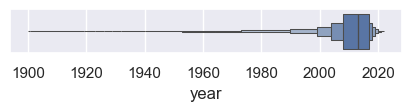

In [66]:
plt.figure(figsize=(4,1), layout='constrained')
sns.boxenplot(data=vehicles_sel, x='year')
plt.show()

In [67]:
# Removing null values from column
vehicles_sel.dropna(subset=['year'], axis='index', inplace=True)
vehicles_sel.shape

(387166, 17)

## Inspect: odometer

1. There are 4,400 null values (0.90% of total)
2. There are also some very high values which we can remove later after modeling if needed

**Let's drop the nulls to get a clean data set**

In [69]:
col='odometer'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - odometer: raw: 4,400 sel: 2,167 => pct: 0.56%


In [70]:
vehicles_sel.describe()[['odometer']].T.style.format('{:,.2f}')

,count,mean,std,min,25%,50%,75%,max
odometer,"384,999.00","99,804.57","206,675.82",0.00,"39,482.00","88,624.00","136,255.00","10,000,000.00"


In [71]:
odo_cutoff_lo = 0
lo = vehicles_sel.query('odometer <= @odo_cutoff_lo')
odo_cutoff_hi = 500000
temp = vehicles_sel.query('odometer > @odo_cutoff_lo and odometer <= @odo_cutoff_hi')
print('Odometer Cutoff: {:,d} ({:,.2f}%) <= lo({:,d}) <= {:,d} ({:,.2f}%) < hi({:,d}) < {:,d} ({:,.2f}%)'
      .format(lo.shape[0], ((lo.shape[0] / vehicles_sel.shape[0]) * 100), 
              odo_cutoff_lo,
              temp.shape[0], ((temp.shape[0] / vehicles_sel.shape[0]) * 100),
              odo_cutoff_hi, 
              vehicles_sel.shape[0] - temp.shape[0], ((1 - temp.shape[0] / vehicles_sel.shape[0]) * 100)))

Odometer Cutoff: 1,084 (0.28%) <= lo(0) <= 382,709 (98.85%) < hi(500,000) < 4,457 (1.15%)


In [72]:
len(vehicles_sel.query('odometer == 0'))

1084

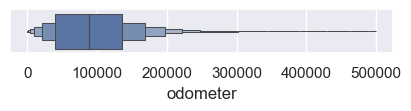

In [73]:
plt.figure(figsize=(4,1), layout='constrained')
# sns.histplot(data=temp, x=col)
sns.boxenplot(data=temp, x=col)
plt.show()

In [74]:
# Removing null values from column
vehicles_sel.dropna(subset=['odometer'], axis='index', inplace=True)
vehicles_sel.shape

(384999, 17)

## Inspect: manufacturer

1. There are 15,983 null values (3.81% of total)

**Let's drop the nulls to get a clean data set**

In [76]:
col='manufacturer'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - manufacturer: raw: 17,646 sel: 14,503 => pct: 3.77%


In [77]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False).head()

,manufacturer,Raw#,Sel#
0,acura,5978,5673
1,alfa-romeo,897,866
2,aston-martin,24,11
3,audi,7573,7014
4,bmw,14699,13592


In [78]:
# Removing null values from column
vehicles_sel.dropna(subset=['manufacturer'], axis='index', inplace=True)
vehicles_sel.shape

(370496, 17)

## Inspect: model

1. Null count is 4,943 (1.22% of total)
2. This is a string field, but has a lot of noise - we should not use it during modeling

**We will _remove this column_ as it would affect the data modeling. We may come back to this after initial modeling**

In [80]:
col='model'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - model: raw: 5,277 sel: 4,368 => pct: 1.18%


In [81]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False).head()

,model,Raw#,Sel#
0,"""t""",1,1
1,#NAME?,41,10
2,"$362.47, $1000 down, oac, 2.9%apr $362.47,luxu...",1,1
3,%,1,0
4,& altima,1,1


In [82]:
vehicles_sel = vehicles_sel.drop('model', axis='columns')
vehicles_sel.shape

(370496, 16)

## Inspect: cylinders

1. Null count is 166,981 (41.33% of total)
2. There are also 1,002 rows with a value of 'other'
3. This is a string field, but has a lot of noise - we should not use it during modeling

**Intuitively, cylinders is likely a large determinant of final price, so we will leave all these values and take this into consideration during modeling**


In [84]:
col='cylinders'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - cylinders: raw: 177,678 sel: 149,847 => pct: 40.44%


In [85]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,cylinders,Raw#,Sel#
0,10 cylinders,1455,1287
1,12 cylinders,209,100
2,3 cylinders,655,509
3,4 cylinders,77642,69942
4,5 cylinders,1712,1522
5,6 cylinders,94169,84601
6,8 cylinders,72062,61887
7,other,1298,801
8,0,177678,149847


## Inspect: fuel

1. Null count is 2,532 (0.63% of total)
2. This is a string field and could contribute to the price models once the nulls are removed

**Let's drop the nulls to get a clean data set**

In [87]:
col='fuel'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - fuel: raw: 3,013 sel: 1,943 => pct: 0.52%


In [88]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,fuel,Raw#,Sel#
0,diesel,30062,20593
1,electric,1698,1493
2,gas,356209,315355
3,hybrid,5170,4797
4,other,30728,26315
5,0,3013,1943


In [89]:
# Removing null values from column
vehicles_sel.dropna(subset=['fuel'], axis='index', inplace=True)
vehicles_sel.shape

(368553, 16)

## Inspect: title_status

1. Null count is 6,612 (1.65% of total)
2. This is a string field and could contribute to the price models once the nulls are removed

**Let's drop the nulls to get a clean data set**

In [91]:
col='title_status'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - title_status: raw: 8,242 sel: 6,475 => pct: 1.76%


In [92]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,title_status,Raw#,Sel#
0,clean,405117,349502
1,lien,1422,1307
2,missing,814,624
3,parts only,198,145
4,rebuilt,7219,6837
5,salvage,3868,3663
6,0,8242,6475


In [93]:
# Removing null values from column
vehicles_sel.dropna(subset=['title_status'], axis='index', inplace=True)
vehicles_sel.shape

(362078, 16)

## Inspect: state

1. There are no nulls
2. This is a string field and there are 50 states plus the DC that can affect price models

**Leave unchanged**

In [95]:
col='state'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - state: raw: 0 sel: 0 => pct: 0.00%


In [96]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False).head()

,state,Raw#,Sel#
0,ak,3474,3289
1,al,4955,4248
2,ar,4038,3079
3,az,8679,7468
4,ca,50614,40505


## Inspect: region

1. There are no nulls
2. This is a string field and there are 404 distinct regions that can affect price models

**Leave unchanged**

In [98]:
col='region'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - region: raw: 0 sel: 0 => pct: 0.00%


In [99]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,region,Raw#,Sel#
0,SF bay area,2936,2492
1,abilene,235,208
2,akron / canton,2211,2115
3,albany,2537,2255
4,albuquerque,2952,2275
...,...,...,...
399,york,777,649
400,youngstown,664,621
401,yuba-sutter,1747,1434
402,yuma,335,235


## Inspect: transmission

1. There are 1,378 null values (0.38% of total)

**Let's drop the nulls to get a clean data set**

In [101]:
col='transmission'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - transmission: raw: 2,556 sel: 1,378 => pct: 0.38%


In [102]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,transmission,Raw#,Sel#
0,automatic,336524,281732
1,manual,25118,20456
2,other,62682,58512
3,0,2556,1378


In [103]:
# Removing null values from column
vehicles_sel.dropna(subset=['transmission'], axis='index', inplace=True)
vehicles_sel.shape

(360700, 16)

## Inspect: drive

1. There are 108,118 null values (29.97% of total)

**Intuitively, drive is likely a determinant of final price, so we will leave all these values and take this into consideration during modeling**


In [105]:
col='drive'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - drive: raw: 130,567 sel: 108,118 => pct: 29.97%


In [106]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,drive,Raw#,Sel#
0,4wd,131904,110988
1,fwd,105517,92388
2,rwd,58892,49206
3,0,130567,108118


## Inspect: size

1. There are 256,362 null values (71.07% of total)

**Intuitively, size is likely a determinant of final price, so we will leave all these values and take this into consideration during modeling**


In [108]:
col='size'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - size: raw: 306,361 sel: 256,362 => pct: 71.07%


In [109]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False)

,size,Raw#,Sel#
0,compact,19384,16450
1,full-size,63465,54756
2,mid-size,34476,30576
3,sub-compact,3194,2556
4,0,306361,256362


## Inspect: type

1. There are 78,400 null values (21.74% of total)

**Intuitively, type is likely a determinant of final price, so we will leave all these values and take this into consideration during modeling**


In [111]:
col='type'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - type: raw: 92,858 sel: 78,400 => pct: 21.74%


In [112]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False).head()

,type,Raw#,Sel#
0,SUV,77284,65236
1,bus,517,300
2,convertible,7731,6449
3,coupe,19204,16033
4,hatchback,16598,14398


## Inspect: paint_color

1. There are 102,994 null values (28.55% of total)

**Intuitively, paint_color can be a determinant of final price, so we will leave all these values and take this into consideration during modeling**


In [114]:
col='paint_color'
raw_null_c = vehicles_raw[col].isnull().sum()
sel_null_c = vehicles_sel[col].isnull().sum()
print('NULL - {}: raw: {:,d} sel: {:,d} => pct: {:,.2f}%'
      .format(col, raw_null_c, sel_null_c, (sel_null_c / vehicles_sel.shape[0]) * 100))

NULL - paint_color: raw: 130,203 sel: 102,994 => pct: 28.55%


In [115]:
value_counts_2df(vehicles_raw, vehicles_sel, 'Raw#', 'Sel#', col, dropna=False).head()

,paint_color,Raw#,Sel#
0,black,62861,55045
1,blue,31223,27657
2,brown,6593,5920
3,custom,6700,5921
4,green,7343,6386


In [116]:
crosscheck = 'PASSED' if (vehicles_cleansed.shape[0] == vehicles_sel.shape[0]
                          and vehicles_cleansed.shape[1] == vehicles_sel.shape[1]) else 'FAILED'
print('CROSSCHECK {}: raw: {} , cleansed: {}, sel: {}'
      .format(crosscheck, vehicles_raw.shape[0], vehicles_cleansed.shape, vehicles_sel.shape))

CROSSCHECK PASSED: raw: 426880 , cleansed: (360700, 16), sel: (360700, 16)


In [117]:
vehicles_sel.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
region,360700,404,columbus,3170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,360700.0,NaN,NaN,NaN,18091.568775,13071.727526,1.0,7000.0,14999.0,26990.0,62981.0
year,360700.0,NaN,NaN,NaN,2011.178007,9.122806,1900.0,2008.0,2013.0,2017.0,2022.0
manufacturer,360700,42,ford,61351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,223668,6,good,113394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,213522,8,6 cylinders,81791,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,360700,5,gas,308197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,360700.0,NaN,NaN,NaN,98543.503208,195802.978631,0.0,39283.0,88632.0,136079.0,10000000.0
title_status,360700,6,clean,348127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,360700,3,automatic,281732,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Multi-variate analysis

In [217]:
# Create some small datasets to speed up debugging
veh_sample_5K = vehicles_sel.sample(n=5000, random_state=42)
veh_sample_10K = vehicles_sel.sample(n=10000, random_state=42)
veh_sample_25K = vehicles_sel.sample(n=25000, random_state=42)
veh_sample_50K = vehicles_sel.sample(n=50000, random_state=42)
veh_sample_5K.head(2)

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
152707,indianapolis,3500,1999.0,lincoln,fair,6 cylinders,gas,254000.0,clean,automatic,NaN,rwd,NaN,NaN,white,in
357124,memphis,18990,2018.0,mazda,good,NaN,gas,18553.0,clean,other,3MZBN1V35JM256052,fwd,NaN,sedan,white,tn


### Price

In [121]:
veh_focus = veh_sample_5K

In [122]:
# plt.figure(figsize=(6,4), layout='constrained')
# sns.scatterplot(data=veh_focus, x='price', y='year', hue='condition')
# plt.show()

In [123]:
# sns.pairplot(veh_focus, hue='year')

In [124]:
temp = vehicles_sel.query('odometer > @odo_cutoff_lo and odometer <= @odo_cutoff_hi')

# sns.displot(data=veh_focus, x='price', y='odometer', kind='kde', hue='condition')
# sns.displot(data=temp, x='price', y='odometer', kind='kde', hue='condition')
# sns.displot(data=temp, x='price', y='odometer', hue='condition')

# Data Considerations

## Goals

* Clean the data to optimize data mining
* Identify guidelines for data gathering for future work